## 1. 数据准备
数据是从[kaggle](https://www.kaggle.com/c/titanic/data)上下载，一共有3个文件
```
├── gender_submission.csv    # 提交示例
├── test.csv     # 测试数据
└── train.csv    # 训练数据
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline  

读取文件，看看文件格式

In [2]:
train = pd.read_csv('train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


表格中各列代表的含义：
+ PassengerID： 乘客ID
+ Survived： 是否存活
+ Pclass：船票类别
+ Name：姓名
+ Sex：性别
+ Age：年龄 
+ SibSp：有无兄弟姐妹和配偶在船上（人数）
+ Parch：有无父母和子女在船上
+ Ticket：票码
+ Fare：票价
+ Cabin：船舱
+ Embarked：出发港

如果要做预测的话，那么我们可以去年PassengerID，Name这直观看起来没有关系的因素。不过这里我觉得Pclass，TIcket，Fare，Cabin，Embarked，SibSp，Parch这几个因素不是很确定，需要下面对数据进行一番探索。

## 2. 数据探索
这里数据探索我们分别对上面有疑问的几个因素进行可视经展示一下，进行简单的探索。

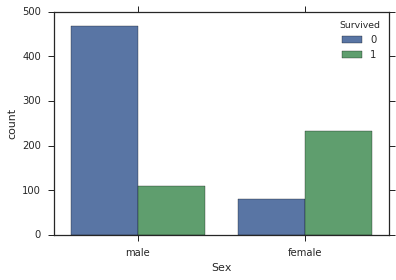

In [4]:
sn.set_style('ticks')
sn.countplot(x='Sex',hue='Survived',data=train)

从上面的图很明显看到女性（female）的生存概率比男性（male）大多了。那性别肯定是一个相关因素。

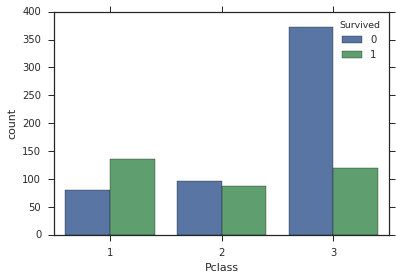

In [5]:
sn.countplot(x='Pclass', hue='Survived', data=train)

看得出，船舱等级（Pclass）从1到3，获救的比例是逐渐下降的。

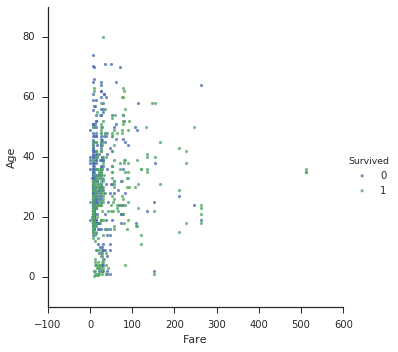

In [15]:
sn.lmplot(x='Fare', y='Age', data=train, hue='Survived', fit_reg=False, scatter_kws={"s": 10})

从年龄上，可以看到在40岁后，获救的概率比较大。20岁以下就难看出有什么规律了。从散点图上也很难看出票价（Fare）和获救的关系。

In [18]:
ticket = train['Ticket']
print "Groups: ", len(set(ticket))
print "Total Num: ", len(ticket)

Groups:  681
Total Num:  891


票码（Ticket）是一类字符串格式的数据格式，初步统计了下Ticket这列有681个不同的值，可以看成是681个不同的类别，其中一共有891个值，差不多每个值都单独成一组。利用`sklearn.preprocessing`中的`LabelEncoder`和`OneHotEncoder`，把这些标签进行转换，转换为稀疏矩阵，行列为891 X 681。

In [35]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
ticket_array = np.array(ticket)
label_encoder = LabelEncoder()
ticket_integer = label_encoder.fit_transform(ticket_array)
ticket_integer = ticket_integer.reshape(len(ticket_integer),1)
ticket_onehot_encoder = OneHotEncoder(sparse=False)
ticket_encoded = ticket_onehot_encoder.fit_transform(ticket_integer)
print ticket_encoded.shape

(891, 681)
